In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

from tsl.datasets import AirQuality
from tsl.nn.models import RNNEncGCNDecModel

In [13]:
def harmonic_month(value):
    value -=1
    frac = 2*np.pi/12
    cos = np.cos(frac*value)
    sin = np.sin(frac*value)
    return cos, sin

In [14]:
base_data = AirQuality(small=True)
df = base_data.dataframe()
df.head()

nodes,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036
channels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
datetime,,,,,,,,,,,,,,,,,,,,,
2014-05-01 01:00:00,138.0,89.0,105.0,98.0,109.0,87.0,88.0,91.0,87.0,87.0,...,101.0,84.0,117.0,21.333334,97.0,87.0,74.0,94.0,112.0,109.0
2014-05-01 02:00:00,124.0,85.0,121.0,107.0,101.0,99.0,105.0,102.0,103.0,94.0,...,100.0,77.0,109.0,78.000000,97.0,84.0,84.0,101.0,123.0,114.0
2014-05-01 03:00:00,127.0,88.0,130.0,115.0,102.0,109.0,114.0,108.0,112.0,109.0,...,103.0,90.0,105.0,77.000000,103.0,83.0,100.0,112.0,143.0,126.0
2014-05-01 04:00:00,129.0,100.0,137.0,123.0,108.0,118.0,118.0,109.0,117.0,111.0,...,110.0,94.0,105.0,90.000000,107.0,88.0,103.0,120.0,138.0,130.0
2014-05-01 05:00:00,119.0,109.0,144.0,129.0,115.0,124.0,130.0,116.0,124.0,114.0,...,105.0,80.0,104.0,83.000000,111.0,85.0,108.0,125.0,145.0,137.0


In [26]:
base_data.index.month.min()
base_data.index.month.max()

12

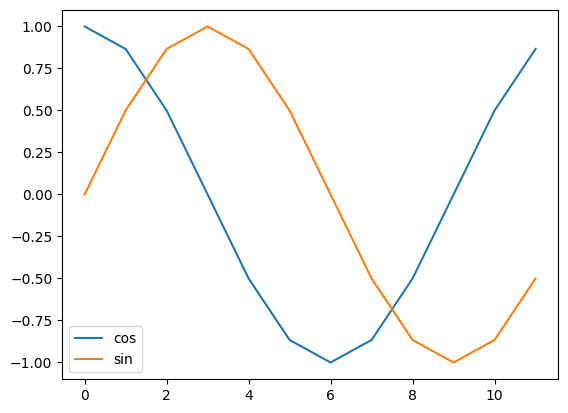

In [15]:
#x = df.index.month
x = np.array([i for i in range(1, 13)])
plt.figure()
cos, sin = harmonic_month(x)
plt.plot(cos, label='cos')
plt.plot(sin, label='sin')
plt.legend()
plt.show()


In [16]:
info_nodes = np.zeros((len(np.unique(df.index.month)), 2, len(df.columns)))
print(info_nodes.shape)
for i in range(info_nodes.shape[0]):
    stats_month = df[df.index.month == i+1].describe().loc[['mean','std'],df.columns].values
    info_nodes[i] = stats_month

(12, 2, 36)


In [17]:
df[df.index.month==3].describe().loc[['mean','std'],df.columns].values.shape

(2, 36)

In [18]:
np.mean(info_nodes[:2], axis=0)

array([[114.06994629,  89.6163063 ,  98.94705963, 110.94504166,
        128.27354813,  99.49757385,  91.68650818, 104.03411484,
        107.33471298, 113.10968399, 117.74293137, 108.01422501,
        108.62822723, 119.2872963 ,  97.58916092, 114.384758  ,
        132.23326874, 125.31050491, 133.57154083, 102.66590118,
        108.86056519, 102.68406296,  98.81391907,  95.17228699,
         93.94474411, 105.61016846,  83.87495804,  86.83967209,
         80.74905777,  87.23506546,  63.53433228,  66.31851768,
         83.05490494, 142.57784271, 138.36075592, 172.04441833],
       [ 94.92816544,  80.94432449,  85.69671631,  91.31048584,
        100.52267075,  86.58031082,  80.70668411,  90.95085144,
         93.95719147,  97.70942307,  99.79201508,  95.98409271,
         97.20289993, 107.70197678,  83.30058289,  95.80736923,
        110.02294922, 106.8343544 , 117.84201813,  89.58314896,
         94.39439011,  93.31116104,  89.24478531,  85.39969254,
         83.11673355,  92.60997772,  74

In [19]:
shape_in = (64, 36, 36, 2)
tensor_base_in = torch.rand(shape_in)

shape_out = (64, 36, 36, 1)
tensor_base_out = torch.rand(shape_out)

In [20]:
info_nodes[2].shape

(2, 36)

In [21]:
np.transpose(np.array([harmonic_month(0) for _ in range(36)])).shape

(2, 36)

In [11]:
s = info_nodes[2]
d = np.transpose(np.array([harmonic_month(0) for _ in range(36)]))
all_array = np.concatenate([s, d])
exog = torch.from_numpy(all_array).float()
exog_flatten = exog.flatten()
exog_flatten = torch.from_numpy(np.concatenate([s.flatten(), np.array(harmonic_month(0))]))
print(exog.shape, exog_flatten.shape)

torch.Size([4, 36]) torch.Size([74])


In [12]:
model = RNNEncGCNDecModel(
    input_size=tensor_base_in.shape,
    hidden_size=12,
    output_size=tensor_base_out.shape,
    exog_size=exog_flatten.shape,
    rnn_layers=1,
    gcn_layers=1,
    rnn_dropout=0.1,
    gcn_dropout=0.1,
    horizon=36,
)

TypeError: empty(): argument 'size' must be tuple of SymInts, but found element of type torch.Size at pos 2

In [5]:
import numpy as np
import pandas as pd

In [6]:
data = np.load('stats_months.npy')
data.shape

(12, 36, 2)

In [24]:
pd.DataFrame(data[0])

,0,1
0,0.511712,0.530252
1,0.324807,0.408001
2,0.386133,0.450855
3,0.468180,0.502974
4,0.613859,0.617223
5,0.406948,0.475720
6,0.360105,0.437522
7,0.418274,0.486599
8,0.442033,0.528910
9,0.492744,0.568220


In [22]:
data.min()

0.0

In [23]:
data.max()

1.0

In [1]:
import torch
from tsl.nn.models import RNNEncGCNDecModel

In [4]:
model = RNNEncGCNDecModel(
            exog_size=0,
            input_size=2,
            output_size=1,
            hidden_size=12,
            horizon=12,
            rnn_layers=2,
            gcn_layers=2,
            rnn_dropout=0,
            gcn_dropout=0,
            activation='sigmoid',
            cell_type='gru',)

In [6]:
for name, param in model.named_parameters():
    print(name, param.shape)

input_encoder.0.weight torch.Size([12, 2])
input_encoder.0.bias torch.Size([12])
encoder.rnn.weight_ih_l0 torch.Size([36, 12])
encoder.rnn.weight_hh_l0 torch.Size([36, 12])
encoder.rnn.bias_ih_l0 torch.Size([36])
encoder.rnn.bias_hh_l0 torch.Size([36])
encoder.rnn.weight_ih_l1 torch.Size([36, 12])
encoder.rnn.weight_hh_l1 torch.Size([36, 12])
encoder.rnn.bias_ih_l1 torch.Size([36])
encoder.rnn.bias_hh_l1 torch.Size([36])
decoder.convs.0.bias torch.Size([12])
decoder.convs.0.lin.weight torch.Size([12, 12])
decoder.convs.0.root_lin.weight torch.Size([12, 12])
decoder.convs.1.bias torch.Size([12])
decoder.convs.1.lin.weight torch.Size([12, 12])
decoder.convs.1.root_lin.weight torch.Size([12, 12])
decoder.readout.readout.mlp.0.affinity.weight torch.Size([12, 12])
decoder.readout.readout.mlp.0.affinity.bias torch.Size([12])
decoder.readout.readout.readout.weight torch.Size([12, 12])
decoder.readout.readout.readout.bias torch.Size([12])


In [16]:
model.input_encoder[0].weight

Parameter containing:
tensor([[ 4.4794e-01,  7.0470e-01],
        [-6.7588e-01, -2.6464e-03],
        [-1.1397e-01,  4.2343e-01],
        [ 5.5736e-01, -2.5788e-01],
        [-6.8061e-01, -6.1959e-01],
        [ 4.3421e-01, -6.9472e-01],
        [-9.1880e-05, -6.5379e-02],
        [-2.7049e-01,  1.7304e-01],
        [ 6.2685e-01,  3.2288e-01],
        [ 3.8166e-01,  3.0513e-01],
        [-6.7515e-01,  1.2032e-01],
        [-3.9315e-01, -1.7540e-01]], requires_grad=True)

In [28]:
type(model.encoder)

tsl.nn.blocks.encoders.recurrent.rnn.RNN

In [29]:
type(model.decoder)

tsl.nn.blocks.decoders.gcn_decoder.GCNDecoder

In [27]:
model.encoder.named_parameters().keys()

AttributeError: 'generator' object has no attribute 'keys'

In [25]:
for i in model.encoder.named_parameters():
    print(i)

('rnn.weight_ih_l0', Parameter containing:
tensor([[ 0.0990, -0.0378,  0.1807, -0.0510,  0.0219,  0.0313, -0.2762, -0.0338,
          0.0803,  0.0402,  0.2441,  0.0265],
        [ 0.2205, -0.2032,  0.2031,  0.2170, -0.2179, -0.0047,  0.0605, -0.2485,
          0.2232,  0.2320, -0.2014, -0.0172],
        [ 0.2441,  0.1554, -0.0588,  0.1039, -0.1749, -0.2055,  0.2667, -0.2342,
         -0.0566, -0.0663, -0.1180, -0.1462],
        [ 0.1526,  0.1275, -0.0824, -0.1643, -0.1721,  0.0282, -0.1430,  0.0539,
          0.1430,  0.2820,  0.0199,  0.0790],
        [-0.2416,  0.0104,  0.2611, -0.2755, -0.1106, -0.2110,  0.0504,  0.1273,
         -0.1696, -0.0968,  0.1964, -0.2623],
        [-0.2777, -0.1171,  0.2350, -0.0312, -0.0165, -0.1364,  0.1719,  0.2585,
          0.0256, -0.0029,  0.0411,  0.1968],
        [ 0.1343, -0.2835, -0.2154,  0.0664, -0.0990, -0.1305,  0.1798, -0.1276,
          0.2076, -0.1794,  0.1799, -0.1569],
        [ 0.2387,  0.1030, -0.0980, -0.0159,  0.2184, -0.0743,  0.17